In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import cv2 as cv
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Rescaling,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
local_zip = '/content/drive/MyDrive/state-farm-distracted-driver-detection.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp')
zip_ref.close()

base_dir='tmp/'
flowers_dir = os.path.join(base_dir, '')

In [ ]:
# Converting data into train data from image generator
train_data=tf.keras.utils.image_dataset_from_directory(
    '/content/tmp/imgs/train',
    validation_split = 0.2,
    subset='training',
    seed=123,
    image_size=(100,100),
    batch_size=128,label_mode='categorical',
)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.


In [ ]:
# Converting data into validation data from image generator
val_data=tf.keras.utils.image_dataset_from_directory(
    '/content/tmp/imgs/train',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(100,100),
    batch_size=128,label_mode='categorical',
)


Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


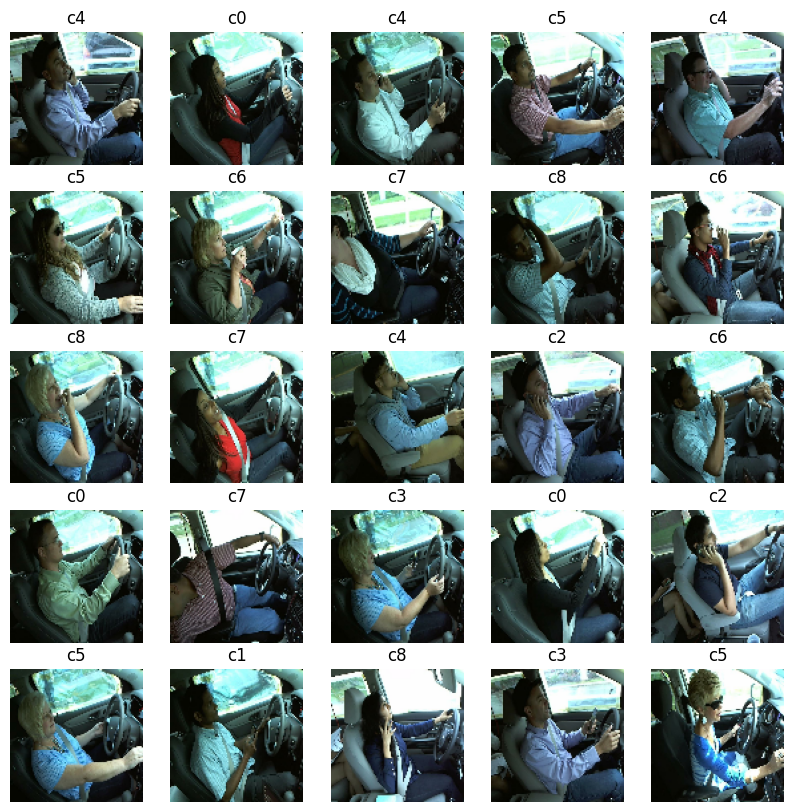

In [ ]:
# Showing some of the images
classes = train_data.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images,labels in train_data.take(1):
  labels = labels.numpy()
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i].argmax()])
    plt.axis('off')


In [ ]:
# creating our model
model = tf.keras.models.Sequential([
    Rescaling(scale = 1/255,input_shape=(100,100,3)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.1),
    Dense(512,activation='relu'),

    Dense(256,activation='relu'),
    Dropout(0.1),
    Dense(10,activation='softmax'),
])

# compiling our model
model.compile(optimizer = Adam(lr=0.01),loss = 'categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                   

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_acc',min_delta=0.01,patience=2)

In [ ]:
# Fitting the Model
history = model.fit(train_data,epochs=10,validation_data=val_data,callbacks=[es])

Epoch 1/10
141/141 [==============================] - 385s 3s/step - loss: 0.9628 - acc: 0.6584 - val_loss: 0.2741 - val_acc: 0.9159
Epoch 2/10
141/141 [==============================] - 390s 3s/step - loss: 0.1589 - acc: 0.9513 - val_loss: 0.1311 - val_acc: 0.9567
Epoch 3/10
141/141 [==============================] - 388s 3s/step - loss: 0.0741 - acc: 0.9765 - val_loss: 0.0472 - val_acc: 0.9888
Epoch 4/10
141/141 [==============================] - 383s 3s/step - loss: 0.0496 - acc: 0.9834 - val_loss: 0.0479 - val_acc: 0.9880
Epoch 5/10
141/141 [==============================] - 381s 3s/step - loss: 0.0405 - acc: 0.9876 - val_loss: 0.0444 - val_acc: 0.9897


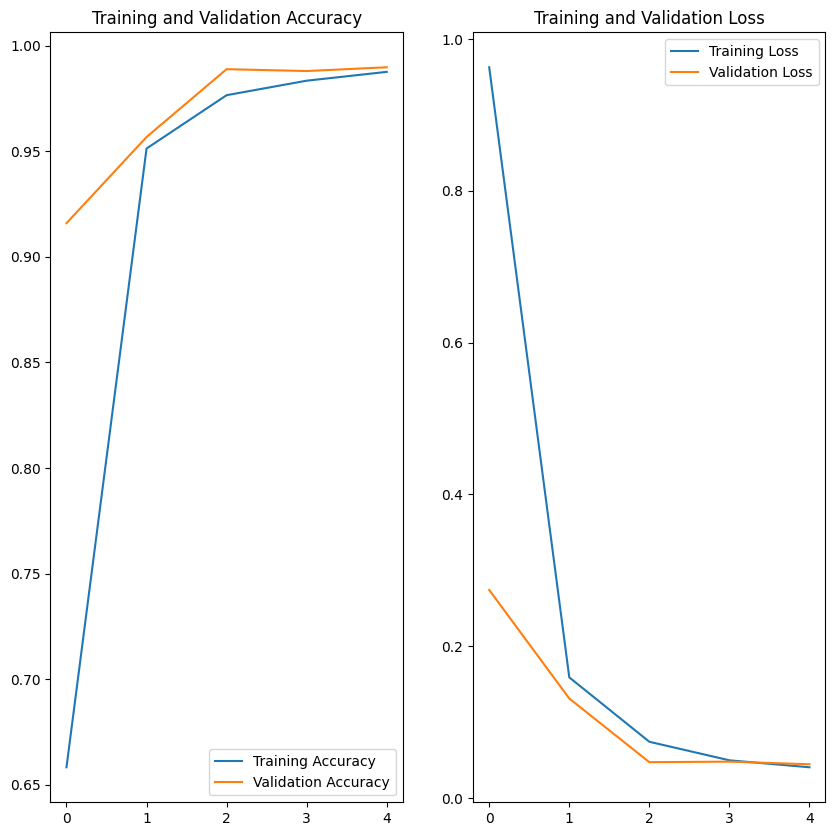

In [ ]:
# visualizing accuracy and losses
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
local_zip = '/content/drive/MyDrive/state-farm-distracted-driver-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp_test')
zip_ref.close()

base_dir = 'tmp_test/'
driver_dir = os.path.join(base_dir, '')

In [ ]:
# converting training data from image generator for prediction
test_data = image_dataset_from_directory(
    '/content/tmp_test/imgs/test',
    batch_size = 128,
    image_size=(100,100),
    labels = None,
    label_mode=None,
    shuffle = False
)

Found 79726 files belonging to 1 classes.


In [ ]:
# function for predicting images
def predict_image(path):
    img = tf.keras.utils.load_img(path).resize((100,100))
    img = np.array(img).reshape((1,100,100,3))
    y = model.predict(img,verbose=False)
    return y

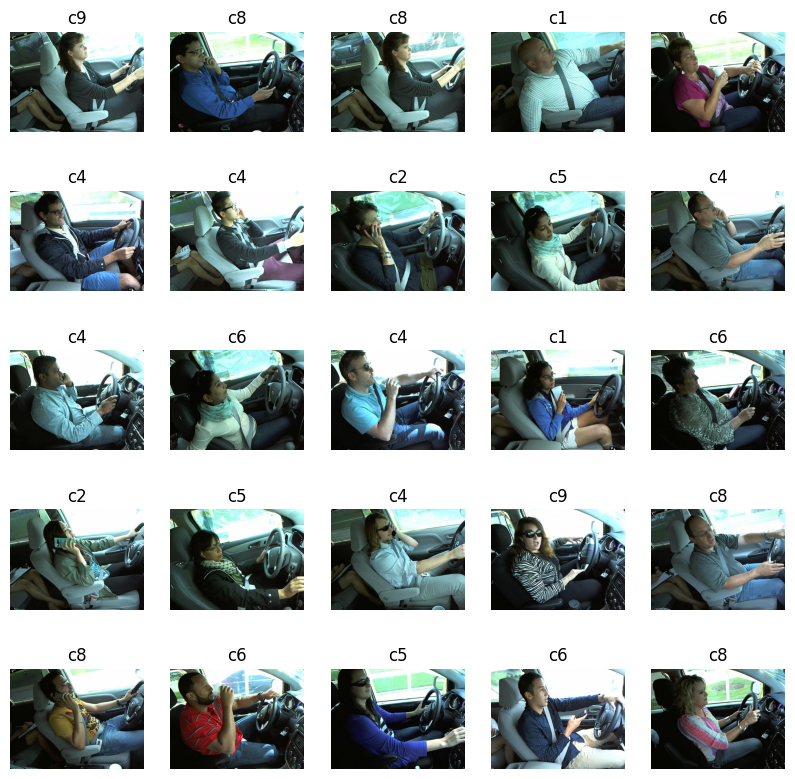

In [ ]:
# predicting some test images
test_path = '/content/tmp_test/test_small'
plt.figure(figsize=(10,10))
i=1
for img_path in os.listdir(test_path)[:25]:
    img_path = os.path.join(test_path,img_path)
    img = tf.keras.utils.load_img(img_path)
    ax = plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.title('c'+str(predict_image(img_path).argmax()))
    plt.axis("off")
    i += 1

In [ ]:
y = model.predict(test_data)

623/623 [==============================] - 518s 831ms/step


In [ ]:
y.shape

(79726, 10)

In [ ]:
# exporting data as given
df = pd.DataFrame(y)
df.columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
filepath = [i.split('/')[-1] for i in test_data.file_paths]
df1 = pd.DataFrame(filepath)
df1.columns = ['img']
df = df1.join(df)
df.to_csv('output.csv',index=False)

In [ ]:
df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,6.701089e-11,1.640802e-13,4.036417e-08,4.331760e-10,1.596831e-09,0.999999,4.226167e-09,2.006657e-07,1.358054e-09,0.000001
1,img_10.jpg,6.220173e-08,8.708701e-08,1.601133e-04,1.810543e-03,2.474956e-07,0.997863,3.793836e-06,1.027798e-04,5.599005e-05,0.000003
2,img_100.jpg,1.488176e-01,8.256547e-04,2.071267e-04,1.947545e-02,7.209542e-03,0.008610,1.437276e-03,1.179065e-03,5.005815e-02,0.762180
3,img_1000.jpg,1.050982e-04,3.562907e-05,2.165891e-04,1.284622e-06,4.126916e-05,0.000015,3.578896e-03,2.058451e-05,9.958962e-01,0.000089
4,img_100000.jpg,4.960492e-03,1.579134e-05,1.819673e-06,2.702374e-04,2.779483e-04,0.000366,9.808846e-06,2.064317e-05,4.464709e-03,0.989612


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79726 entries, 0 to 79725
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   img     79726 non-null  object 
 1   c0      79726 non-null  float32
 2   c1      79726 non-null  float32
 3   c2      79726 non-null  float32
 4   c3      79726 non-null  float32
 5   c4      79726 non-null  float32
 6   c5      79726 non-null  float32
 7   c6      79726 non-null  float32
 8   c7      79726 non-null  float32
 9   c8      79726 non-null  float32
 10  c9      79726 non-null  float32
dtypes: float32(10), object(1)
memory usage: 3.6+ MB
